# ETL phase 2, Data Cleaning - Missing Data

In [94]:
#!pip install pandas
#!pip install os
#!pip install seaborn
import pandas
import pyodbc
import numpy as np
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import time

In [107]:
# Set path
my_path = r"C:\MyDataFiles\Data_CCBIS_202107"
if not os.path.exists(my_path):
    os.makedirs(my_path)
    print("Directory created: " + my_path)
# Clean log files
else:
    logExtension = ".log"
    auditExtension = '.xlsx'
    for root_folder, folders, files in os.walk(my_path):
        for file in files:
            file_path = os.path.join(root_folder, file)
            file_extension = os.path.splitext(file)[1]
            if file_extension == logExtension:
                if not os.remove(file_path):
                    print("File deleted successfully: " + file_path)
                else:
                    print("Unable to delete the " + file_path)
            if file_extension == auditExtension and file != audit_fileName:
                if not os.remove(file_path):
                    LOG.info("File deleted successfully: " + file_path)
                else:
                    LOG.info("Unable to delete the " + file_path)
# Create data directors
my_path_CCBIS = my_path + "\CCBIS"
my_path_CCBISDW = my_path + "\CCBISDW"
my_path_cleaned = my_path + "\cleaned"
directors =  [my_path_CCBIS, my_path_CCBISDW, my_path_cleaned]
for director in directors:
    if not os.path.exists(director):
        os.makedirs(director)
        print('Directory created: ' + director)

In [40]:
#=============================================================================
#=== Set Logging configeration
#=============================================================================
# Set log file name
log_fileName = time.strftime("%Y%m%d") + '_CCBIS.log'
audit_fileName = time.strftime("%Y%m%d") + '_CCBIS_audit.xlsx'
# Set log file
os.chdir(my_path)
LOG = logging.getLogger(log_fileName)
LOG.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler(log_fileName, 'w') # 'w'-overwrite; 'a'-append
fh.setLevel(logging.INFO)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s:[%(levelname)s] %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
LOG.addHandler(fh)
LOG.addHandler(ch)

In [157]:
#=============================================================================
#=== Extract from CCBIS to CSV
#=============================================================================

print('==== Extract: from CCBIS(SQL Server) ====')

#Set up SQL Server connector
os.chdir(my_path_CCBIS)
sql_conn = pyodbc.connect('DRIVER={SQL Server}; SERVER=localhost; DATABASE=CCBIS; UID=sa; PWD=SQLServer2019')

# get table name list
print('The tables are creating in ' + my_path_CCBIS + ':')
tables = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_NAME != 'sysdiagrams'"
tbls = pandas.read_sql(tables, sql_conn)
for index, row in tbls.iterrows():
    tableName = row['TABLE_NAME']
    print('--' + str(index+1) + '. ' + tableName + '.csv')  

    # read from SQL Server CCBIS
    query = "SELECT * FROM [dbo].[" + row['TABLE_NAME'] + "]"  
    df = pandas.read_sql(query, sql_conn)

    # write to CCBIS/*.csv
    df.to_csv(my_path_CCBIS + "/" + tableName + '.csv', index = False)

print('Extract Completed Successfully - ' + str(len(os.listdir('.'))) + ' files created in ' + my_path_CCBIS)

==== Extract: from CCBIS(SQL Server) ====
The tables are creating in C:\MyDataFiles\Data_CCBIS_202107\CCBIS:
--1. CDR.csv
--2. DimAgent.csv
--3. DimCustomer.csv
--4. DimGeography.csv
--5. DimHandleType.csv
--6. DimProduct.csv
--7. DimProductGroup.csv
--8. DimServiceType.csv
--9. DimSeverifyType.csv
Extract Completed Successfully - 9 files created in C:\MyDataFiles\Data_CCBIS_202107\CCBIS


## --Cleaning Duplicate Data

In [161]:
# Cleaning Duplicate Data
os.chdir(my_path_CCBIS)
print("==== Cleaning Duplicate Data ====")

for file in glob.glob("*.csv"):
    # Get table info
    tableName = str(file)[:-4]
    pkNameQuery = "SELECT Col.Column_Name as PkName from INFORMATION_SCHEMA.TABLE_CONSTRAINTS Tab, INFORMATION_SCHEMA.CONSTRAINT_COLUMN_USAGE Col WHERE Col.Constraint_Name = Tab.Constraint_Name AND Col.Table_Name = Tab.Table_Name AND Constraint_Type = 'PRIMARY KEY' AND Col.Table_Name = '" + tableName +"'"
    pkList = list(pandas.read_sql(pkNameQuery, sql_conn)["PkName"])

    # Get data
    df = pandas.read_csv(file, index_col = pkList)
    size_org = df.shape[0]
    print('\nFrom: ' + file + str(df.shape))


    # Drop duplicate
    df.drop_duplicates(keep="first", inplace=True)  
    size_cleaned = df.shape[0]
    newFile = str(file)[:-4] + "_clean.csv"   
    print('To:   ' + newFile + str(df.shape))
    num_duplication = size_org - size_cleaned
    if num_duplication > 0:
        print('------[Duplication] ' + str(num_duplication) + ' records dropped from ' + file)

    # Write to new file
    df.to_csv(my_path_cleaned + "/" + newFile)

    os.chdir(my_path_CCBIS)

==== Cleaning Duplicate Data ====

From: CDR.csv(16100, 17)
To:   CDR_clean.csv(16000, 17)
------[Duplication] 100 records dropped from CDR.csv

From: DimAgent.csv(101, 4)
To:   DimAgent_clean.csv(100, 4)
------[Duplication] 1 records dropped from DimAgent.csv

From: DimCustomer.csv(18484, 28)
To:   DimCustomer_clean.csv(18484, 28)

From: DimGeography.csv(655, 9)
To:   DimGeography_clean.csv(655, 9)

From: DimHandleType.csv(3, 1)
To:   DimHandleType_clean.csv(3, 1)

From: DimProduct.csv(25, 2)
To:   DimProduct_clean.csv(25, 2)

From: DimProductGroup.csv(5, 1)
To:   DimProductGroup_clean.csv(5, 1)

From: DimServiceType.csv(16, 1)
To:   DimServiceType_clean.csv(16, 1)

From: DimSeverifyType.csv(3, 1)
To:   DimSeverifyType_clean.csv(3, 1)


## -- Cleaning Missing Data

In [162]:
# Cleaning Missing Date

os.chdir(my_path_CCBIS)
print("==== Cleaning Missing Data ====")
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.

for file in glob.glob("*.csv"):
    # Get table info
    tableName = str(file)[:-4]
    pkNameQuery = "SELECT Col.Column_Name as PkName from INFORMATION_SCHEMA.TABLE_CONSTRAINTS Tab, INFORMATION_SCHEMA.CONSTRAINT_COLUMN_USAGE Col WHERE Col.Constraint_Name = Tab.Constraint_Name AND Col.Table_Name = Tab.Table_Name AND Constraint_Type = 'PRIMARY KEY' AND Col.Table_Name = '" + tableName +"'"
    pkList = list(pandas.read_sql(pkNameQuery, sql_conn)["PkName"])

    # Get data
    df = pandas.read_csv(file, index_col = pkList)
    size_org = df.shape[0]
    cols = df.columns
    print('\nFrom: ' + file + str(df.shape))
    newFile = str(file)[:-4] + "_clean.csv"   
    print('To:   ' + newFile + str(df.shape))

    # set numeric columns
    df_numeric = df.select_dtypes(include=[np.number])
    numeric_cols = df_numeric.columns.values
   
    # set non numeric columns
    df_non_numeric = df.select_dtypes(exclude=[np.number])
    non_numeric_cols = df_non_numeric.columns.values
     
    for col in df.columns:
        missing = df[col].isnull()
        num_missing = np.sum(missing)
        pct_missing = np.mean(missing)
             
        if num_missing > 0: 
            # Print Missing Data Percentage List - % of missing.
            #print('------[Missing] ' + file + ' {} - {}%'.format(col, round(pct_missing*100)) + ', ' + str(num_missing) + ' missing, ')
            df['{}_ismissing'.format(col)] = missing
            # When numeric, fill with midian value 
            if col in numeric_cols:
                med = df[col].median()
                df[col] = df[col].fillna(med)
                print('------[Missing] ' + file + ' {} - {}%'.format(col, round(pct_missing*100)) + ', ' + str(num_missing) + ' missed, filling with ' + str(med))
            # When not numeric, fill with most frequent value     
            else:
                top = df[col].describe()['top'] # impute with the most frequent value.
                df[col] = df[col].fillna(top)
                print('------[Missing] ' + file + ' {} - {}%'.format(col, round(pct_missing*100)) + ', ' + str(num_missing) + ' missed, filling with "' + top + '"')

# Write to new file
    df.to_csv(my_path_cleaned + "/" + newFile)

    os.chdir(my_path_CCBIS)

==== Cleaning Missing Data ====

From: CDR.csv(16100, 17)
To:   CDR_clean.csv(16100, 17)

From: DimAgent.csv(101, 4)
To:   DimAgent_clean.csv(101, 4)

From: DimCustomer.csv(18484, 28)
To:   DimCustomer_clean.csv(18484, 28)
------[Missing] DimCustomer.csv Title - 99%, 18383 missing, filled with "Mr."
------[Missing] DimCustomer.csv MiddleName - 42%, 7830 missing, filled with "A"
------[Missing] DimCustomer.csv LastName - 0%, 1 missing, filled with "Diaz"
------[Missing] DimCustomer.csv Suffix - 100%, 18481 missing, filled with "Jr."
------[Missing] DimCustomer.csv AddressLine2 - 98%, 18172 missing, filled with "Verkaufsabteilung"

From: DimGeography.csv(655, 9)
To:   DimGeography_clean.csv(655, 9)

From: DimHandleType.csv(3, 1)
To:   DimHandleType_clean.csv(3, 1)

From: DimProduct.csv(25, 2)
To:   DimProduct_clean.csv(25, 2)

From: DimProductGroup.csv(5, 1)
To:   DimProductGroup_clean.csv(5, 1)

From: DimServiceType.csv(16, 1)
To:   DimServiceType_clean.csv(16, 1)

From: DimSeverifyType

## -- Cleaning Outliner

==== Cleaning Outliner ====

From: CDR.csv(16100, 17)


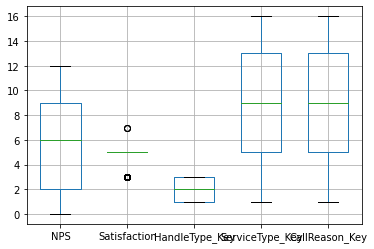

In [174]:
# Cleaning Missing Date

os.chdir(my_path_CCBIS)
print("==== Cleaning Outliner ====")

for file in glob.glob("CDR.csv"):
    # Get table info
    tableName = str(file)[:-4]
    pkNameQuery = "SELECT Col.Column_Name as PkName from INFORMATION_SCHEMA.TABLE_CONSTRAINTS Tab, INFORMATION_SCHEMA.CONSTRAINT_COLUMN_USAGE Col WHERE Col.Constraint_Name = Tab.Constraint_Name AND Col.Table_Name = Tab.Table_Name AND Constraint_Type = 'PRIMARY KEY' AND Col.Table_Name = '" + tableName +"'"
    pkList = list(pandas.read_sql(pkNameQuery, sql_conn)["PkName"])

    # Get data
    df = pandas.read_csv(file, index_col = pkList)
    size_org = df.shape[0]
    cols = df.columns
    print('\nFrom: ' + file + str(df.shape))

    df.set_index = (['CustomerKey'])
    df.boxplot(['NPS','Satisfaction', 'HandleType_Key', 'ServiceType_Key', 'CallReason_Key'], widths = 0.6)

#     sns.boxplot(y=['NPS','Satisfaction', 'HandleType_Key', 'ServiceType_Key', 'CallReason_Key'], 
#                  data=df, 
#                  palette="colorblind")
# # make grouped stripplot
# sns.stripplot(y=['NPS','Satisfaction', 'HandleType_Key', 'ServiceType_Key', 'CallReason_Key'], 
#                    data=df, 
#                    jitter=True,
#                    dodge=True, 
#                    marker='o', 
#                    alpha=0.5,
#                    color='grey')